In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

class TextClassifier:
    def __init__(self, embedding_model: str = 'paraphrase-multilingual-MiniLM-L12-v2'):
        self.embedding_model = SentenceTransformer(embedding_model)
        self.label_encoder = LabelEncoder()
        self.classifier = LogisticRegression(max_iter=1000)

    def prepare_data(self, df: pd.DataFrame, text_col: str, label_col: str):
        y = self.label_encoder.fit_transform(df[label_col])
        X = self.embedding_model.encode(df[text_col].tolist())
        
        return X, y

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.classifier.fit(X_train, y_train)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.classifier.predict(X_test)

    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray):
        y_pred = self.predict(X_test)
        print(classification_report(
            y_test, 
            y_pred, 
            labels=np.unique(y_test),
        ))


In [40]:
df = pd.read_csv('train.csv')
df.dropna(inplace=True)
df = df.head(500)
classifier = TextClassifier()
X, y = classifier.prepare_data(df, text_col='description', label_col='class')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)
    

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.14      0.25      0.18         4
           8       1.00      0.25      0.40         4
           9       0.54      0.78      0.64         9
          10       0.00      0.00      0.00         1
          11       0.50      0.33      0.40         3
          12       1.00      0.50      0.67         6
          13       0.44      0.80      0.57        10
          14       0.33      0.50      0.40         4
          15       1.00      1.00      1.00         1
          16       0.36      0.36      0.36        11
          17       0.00      0.00      0.00         1
          19       0.73      0.73      0.73        11
          20       0.33    

c:\Programmation\School\TPS\RakutenMultimodalClassification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\RakutenMultimodalClassification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programmation\School\TPS\RakutenMultimodalClassification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

<Axes: >

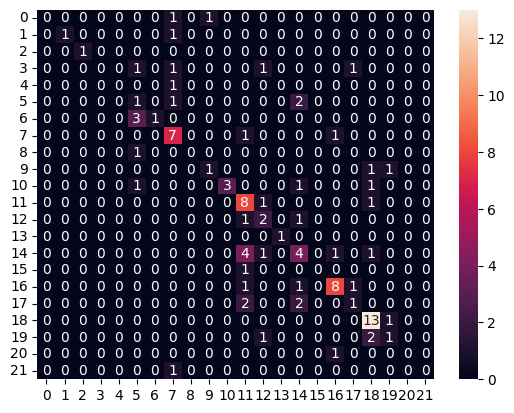

In [43]:
# show confusion matrix with sns
y_pred = classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')